In [1]:
import os
import urllib.request
if not os.path.exists("lab11_1_lib.py"):
    urllib.request.urlretrieve("https://nthu-datalab.github.io/ml/labs/11-1_CNN/lab11_1_lib.py", "lab11_1_lib.py")

In [2]:
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict
from lab11_1_lib import draw_timeline

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)

all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/virginia_opossum
oregon_wildlife/raccoon
oregon_wildlife/red_fox
oregon_wildlife/bald_eagle
oregon_wildlife/black_bear
oregon_wildlife/raven
oregon_wildlife/nutria
oregon_wildlife/sea_lions
oregon_wildlife/deer
oregon_wildlife/cougar

total img num: 7168


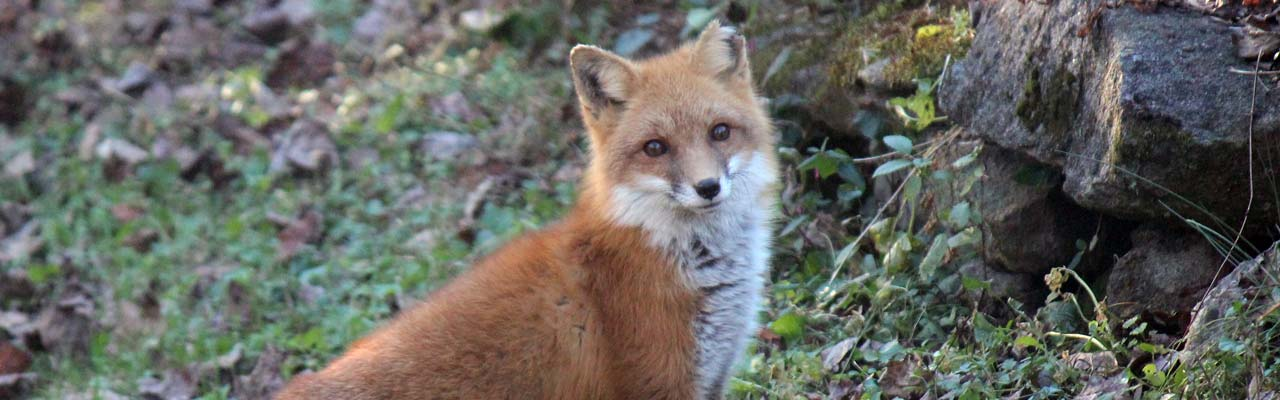

red_fox


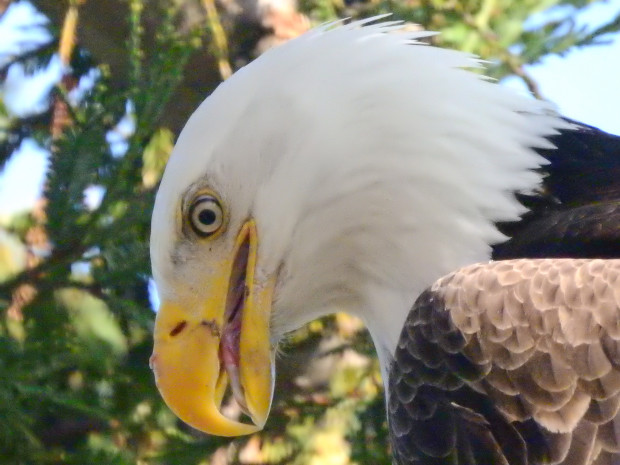

bald_eagle


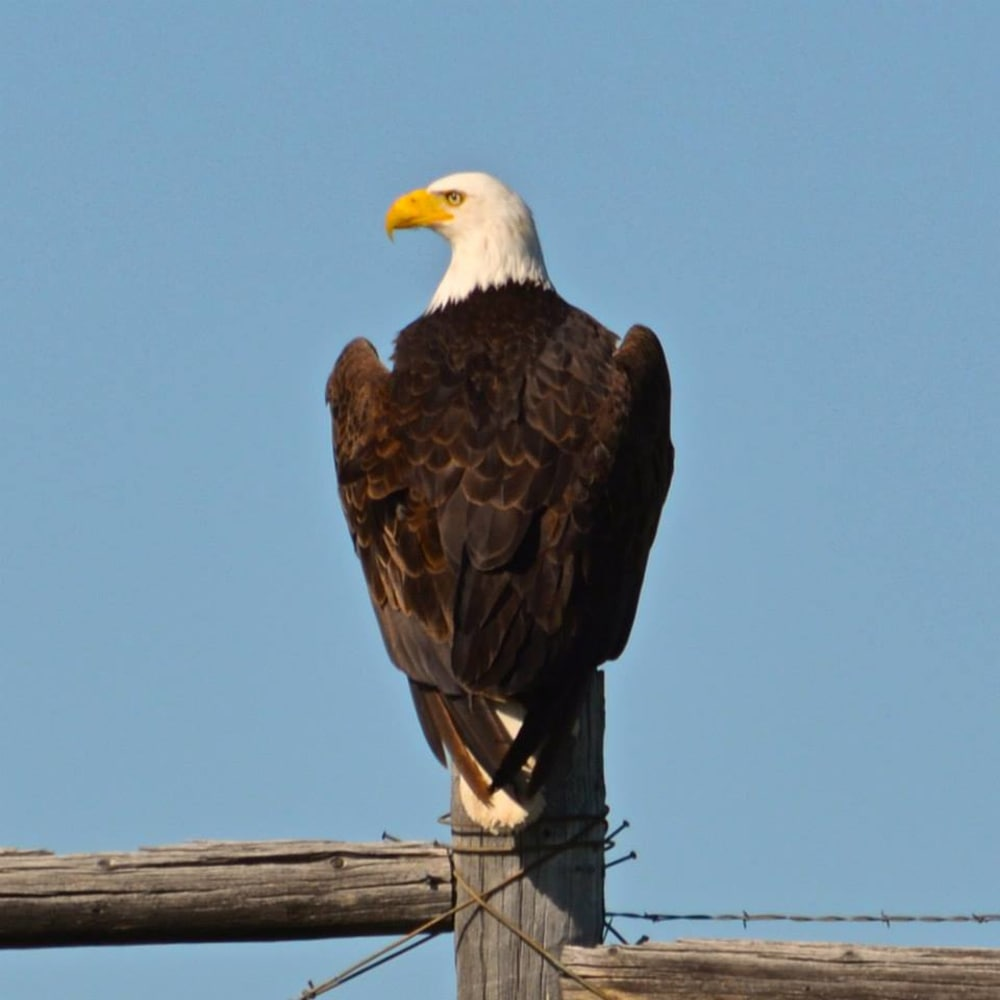

bald_eagle


In [ ]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [5]:
# get the label
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total label
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [6]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [7]:
# get the label data
all_image_label = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 label indices: ", all_image_label[:10])

First 10 label indices:  [3, 6, 7, 6, 9, 7, 5, 9, 5, 9]


In [8]:
# Create training and testing sets using an 80-20 split
img_path_train, img_path_test, label_train, label_test = train_test_split(all_image_paths,
                                all_image_label,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_test)))

training data: 5734
testing data: 1434


In [9]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])

with open('test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_test, label_test):
        writer.writerow([img_path, label])

In [10]:
# Feel free to change IMAGE_SIZE_CROPPED if using random_crop in your data augmentation process, but make sure the input resize back to (300,300,3) before feed into VGG16
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [11]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string), # steps: [("Open",), ("Read",)]
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32), # timings: [(open_enter, open_elapsed), (read_enter, read_elapsed)]
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32), # counters: [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, example_idx)]
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32) # label
    )

    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename, open_file, read_file):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        img_paths, label = open_file(filename)
        open_elapsed = time.perf_counter() - open_enter
        # ----------------

        # Reading the file
        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = read_file(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                label[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename, open_file, read_file):
        def generator_func(instance_idx, filename):
            return cls._generator(instance_idx, filename, open_file, read_file)

        return tf.data.Dataset.from_generator(
            generator_func,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [12]:
def open_file(filename):
    rows = pd.read_csv(filename.decode("utf-8"))
    img_paths = rows['img_path'].tolist()
    label = rows['label'].tolist()
    return img_paths, label

def read_file(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('train.csv', open_file, read_file)

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('test.csv', open_file, read_file)

In [13]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE, drop_remainder=True)
dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test).batch(BATCH_SIZE, drop_remainder=True)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[2.7996746e+04 7.3176250e-03]
 [2.7996754e+04 1.6583288e-01]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 0  0 -1]
 [ 0  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


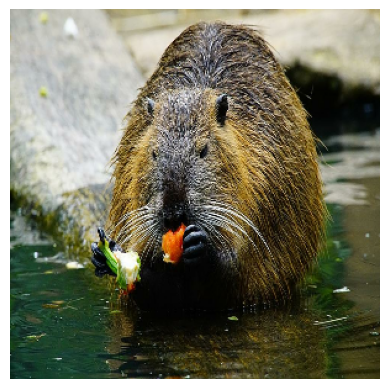

nutria


In [14]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    print(index_to_label[label[0].numpy()])

In [15]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output))

In [16]:
wild_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0     

In [17]:
# save the initialization of weights
wild_model.save_weights('wild_model.h5')

In [18]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [19]:
@tf.function
def train_step(image, label):
    with tf.GradientTape() as tape:
        predictions = wild_model(image, training=True)
        loss = loss_object(label, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(label, predictions)

@tf.function
def test_step(image, label):
    predictions = wild_model(image, training=False)
    loss = loss_object(label, predictions)

    test_loss(loss)
    test_accuracy(label, predictions)

In [20]:
def timelined_benchmark(dataset_train, dataset_test, EPOCHS):
    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    print("start time: ", start_time)
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()

        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, image, label in tqdm(dataset_train, total=math.floor(len(img_path_train)/BATCH_SIZE)):
            time.sleep(0.05)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            # record training time
            train_enter = time.perf_counter()
            train_step(image, label)
            train_elapsed = time.perf_counter() - train_enter

            time.sleep(0.05)

            train_time = tf.concat([tf.fill([times.shape[0], 1], train_enter), tf.fill([times.shape[0], 1], train_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Train")], axis=0)
            times_acc = tf.concat([times_acc, train_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        tf.print("testing:")
        for steps, times, values, image, label in tqdm(dataset_test, total=math.floor(len(img_path_test)/BATCH_SIZE)):
            time.sleep(0.05)

            steps_acc = tf.concat([steps_acc, tf.reshape(steps, (steps.shape[0]*steps.shape[1], 1))], axis=0)
            times_acc = tf.concat([times_acc, tf.reshape(times, (times.shape[0]*times.shape[1], 2))], axis=0)
            values_acc = tf.concat([values_acc, tf.reshape(values, (values.shape[0]*values.shape[1], 3))], axis=0)

            test_enter = time.perf_counter()
            test_step(image, label)
            test_elapsed = time.perf_counter() - test_enter

            time.sleep(0.05)

            test_time = tf.concat([tf.fill([times.shape[0], 1], test_enter), tf.fill([times.shape[0], 1], test_elapsed)], axis=1) # shape=(times.shape[0], 2)
            steps_acc = tf.concat([steps_acc, tf.fill([steps.shape[0], 1], "Test")], axis=0)
            times_acc = tf.concat([times_acc, test_time], axis=0)
            values_acc = tf.concat([values_acc, values[:,-1,:]], axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat([steps_acc, [["Epoch"]]], axis=0)
        times_acc = tf.concat([times_acc, [(epoch_enter, epoch_elapsed)]], axis=0)
        values_acc = tf.concat([values_acc, [[-1, epoch, -1]]], axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [ ]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test, EPOCHS=3)

start time:  155.494892617
training:


100%|██████████| 5734/5734 [1:05:33<00:00,  1.46it/s]

testing:



100%|██████████| 1434/1434 [15:00<00:00,  1.59it/s]

Epoch 1, Loss: 4.7408, Accuracy: 11.0220, test Loss: 2.3143, test Accuracy: 9.2748
training:



100%|██████████| 5734/5734 [10:32<00:00,  9.07it/s]

testing:



100%|██████████| 1434/1434 [02:38<00:00,  9.07it/s]

Epoch 2, Loss: 2.7797, Accuracy: 10.5685, test Loss: 2.3010, test Accuracy: 10.8787
training:



100%|██████████| 5734/5734 [10:34<00:00,  9.04it/s]

testing:



100%|██████████| 1434/1434 [02:38<00:00,  9.04it/s]

Epoch 3, Loss: 2.3596, Accuracy: 10.7081, test Loss: 2.3112, test Accuracy: 9.7629
Execution time: 6417.562631749


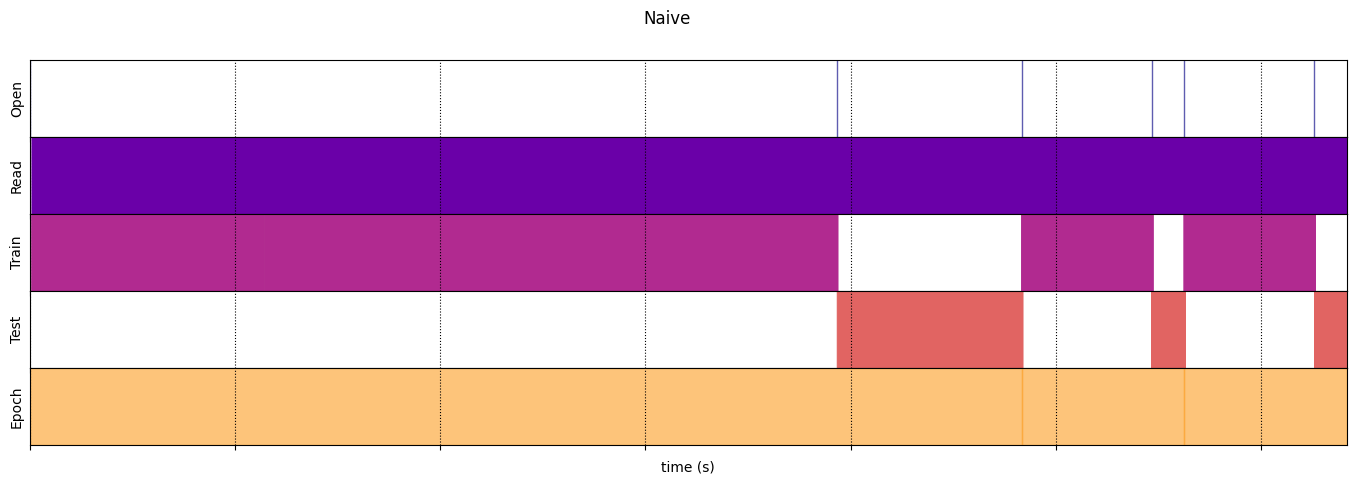

In [ ]:
draw_timeline(timeline=timeline_Naive, title="Naive", min_width=3000)

### Augmentation

In [21]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions with map_decorator before calling map
IMAGE_SIZE_CROPPED = 224 #VGG models commonly use 224*224 images as input
def map_decorator(func):
    def wrapper(steps, times, values, image, label):
        # Use a tf.py_function to prevent auto-graph from compiling the method
        return tf.py_function(
            func,
            inp=(steps, times, values, image, label),
            Tout=(steps.dtype, times.dtype, values.dtype, image.dtype, tf.float32)
        )
    return wrapper

@map_decorator
def map_fun_with_augment(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    # record the enter time into map_fun()
    map_enter = time.perf_counter()

    image = tf.reshape(image,[IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1, 2, 0]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(image, [300,300])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3) #brightness be adjusted within the range of [-0.2, 0.2] times the original brightness
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.5, upper=1.5)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_augment(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    # record the enter time into map_fun_test()
    map_enter = time.perf_counter()

    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [300,300])
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter
    # ----------------

    return tf.concat((steps, [["Map"]]), axis=0),\
           tf.concat((times, [[map_enter, map_elapsed]]), axis=0),\
           tf.concat((values, [values[-1]]), axis=0),\
           distorted_image,\
           label


In [22]:
BUFFER_SIZE = 10000
BATCH_SIZE = 16

dataset_train_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                                    .map(map_fun_with_augment)\
                                                    .shuffle(BUFFER_SIZE)\
                                                    .batch(BATCH_SIZE, drop_remainder=True)
dataset_test_augmentation = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                                    .map(map_fun_test_with_augment)\
                                                    .shuffle(BUFFER_SIZE)\
                                                    .batch(BATCH_SIZE, drop_remainder=True)

(300, 300, 3)


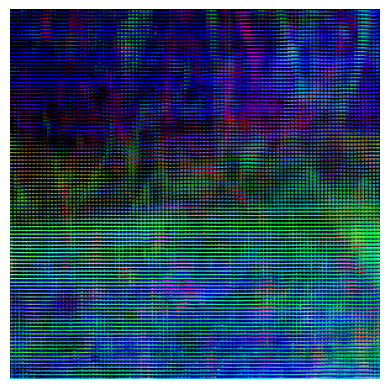

deer
(300, 300, 3)


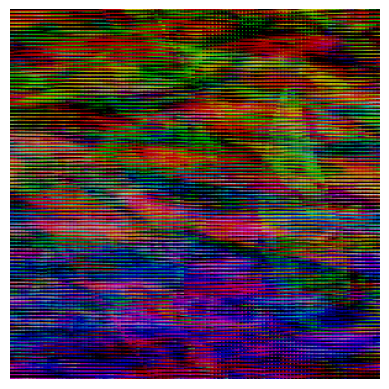

sea_lions
(300, 300, 3)


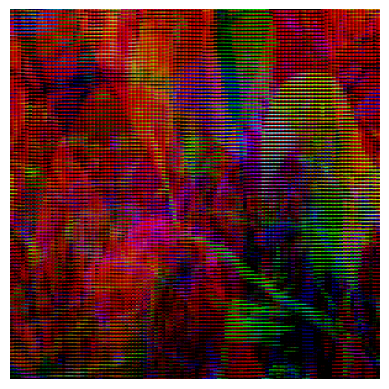

bald_eagle
(300, 300, 3)


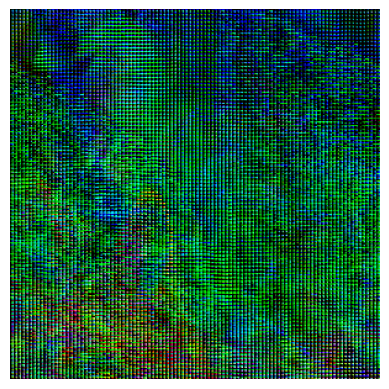

red_fox
(300, 300, 3)


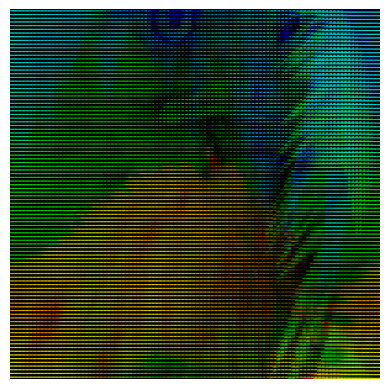

bald_eagle


In [ ]:
for steps, timings, counters, img, label in dataset_train_augmentation.take(5):
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    label_array = label[0].numpy()
    print(index_to_label[np.where(label_array == 1)[0][0]])

In [23]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.legacy.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=3)

start time:  1468.018327014
training:


100%|██████████| 358/358 [28:27<00:00,  4.77s/it]

testing:



100%|██████████| 89/89 [06:20<00:00,  4.28s/it]

Epoch 1, Loss: 3.7827, Accuracy: 13.2682, test Loss: 2.2807, test Accuracy: 12.5702
training:



100%|██████████| 358/358 [07:45<00:00,  1.30s/it]

testing:



100%|██████████| 89/89 [01:51<00:00,  1.26s/it]

Epoch 2, Loss: 2.2959, Accuracy: 12.1334, test Loss: 2.2974, test Accuracy: 9.4803
training:



100%|██████████| 358/358 [07:45<00:00,  1.30s/it]

testing:



100%|██████████| 89/89 [01:51<00:00,  1.26s/it]

Epoch 3, Loss: 2.3024, Accuracy: 11.0510, test Loss: 2.2992, test Accuracy: 8.9888
Execution time: 3242.655723911


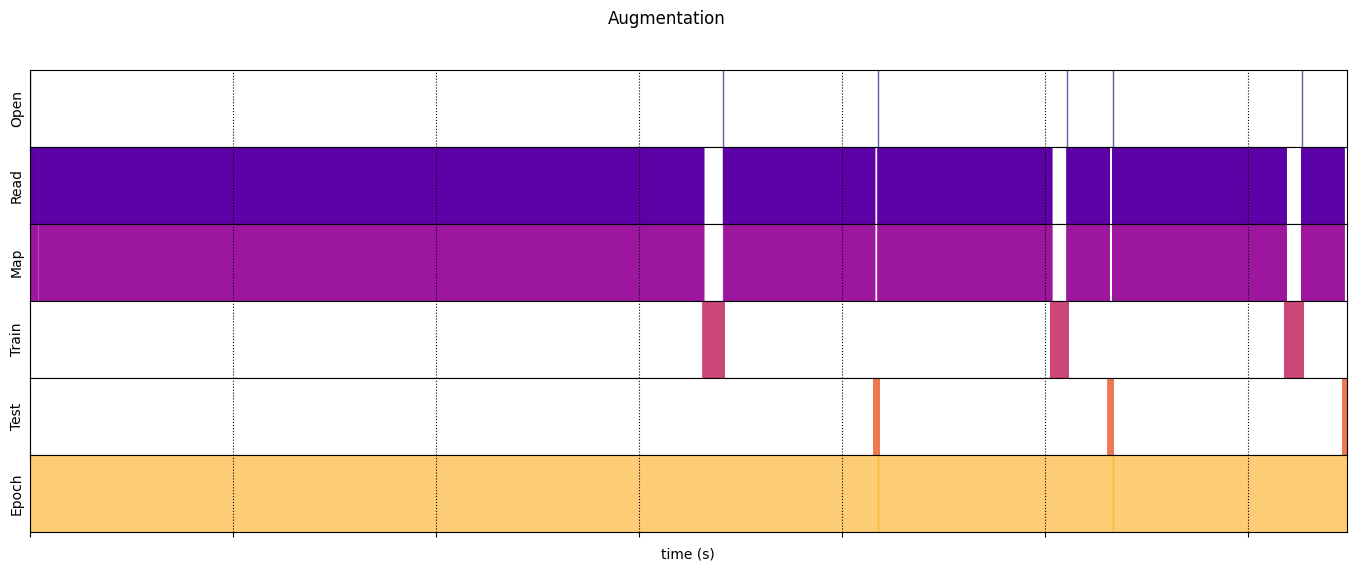

In [ ]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

### Optimization

In [ ]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated
IMAGE_SIZE_CROPPED = 224

def map_fun_with_augment_optim(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    map_enter = time.perf_counter()

    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label, 10)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,IMAGE_DEPTH])
    distorted_image = tf.image.resize(image, [300,300])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=0.3)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.5, upper=1.5)
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

@map_decorator
def map_fun_test_with_augment_optim(steps, times, values, image, label):
    # sleep to avoid concurrency issue
    time.sleep(0.05)

    map_enter = time.perf_counter()

    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize(image, [300,300])
    #distorted_image = tf.image.resize(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED])
    distorted_image = tf.image.per_image_standardization(distorted_image)

    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 16

dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_with_augment_optim, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun_test_with_augment_optim, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)

(300, 300, 3)


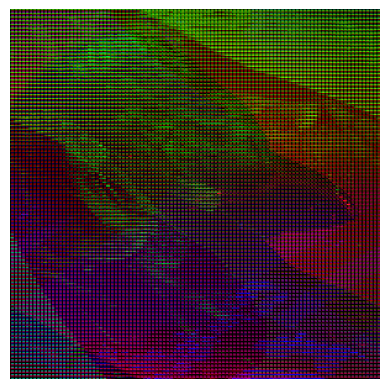

raven
(300, 300, 3)


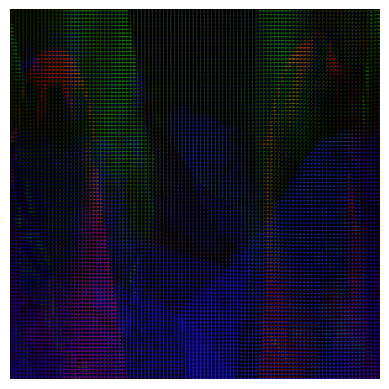

sea_lions
(300, 300, 3)


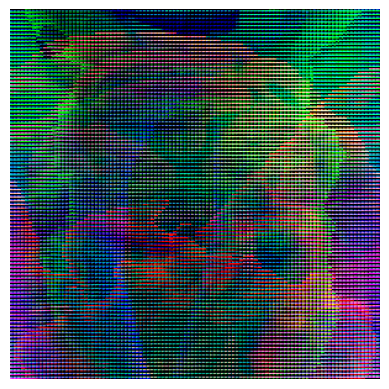

cougar
(300, 300, 3)


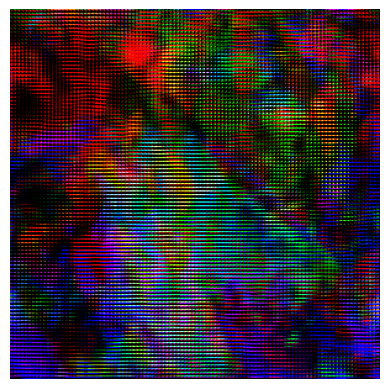

black_bear
(300, 300, 3)


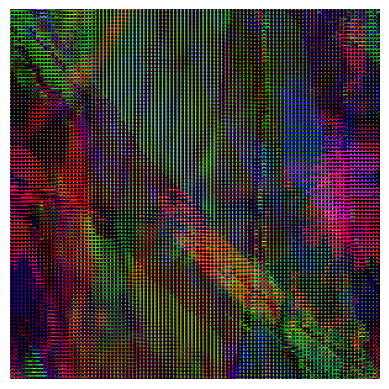

bald_eagle


In [ ]:
for steps, timings, counters, img, label in dataset_train_optimized.take(5):
    print(img[0].shape)
    plt.imshow(img[0])
    plt.axis('off')
    plt.show()
    label_array = label[0].numpy()
    print(index_to_label[np.where(label_array == 1)[0][0]])

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized, EPOCHS=3)

start time:  5299.615949575
training:


100%|██████████| 358/358 [02:08<00:00,  2.78it/s]

testing:



100%|██████████| 89/89 [00:31<00:00,  2.79it/s]

Epoch 1, Loss: 4.3218, Accuracy: 10.9462, test Loss: 2.3296, test Accuracy: 12.0084
training:



100%|██████████| 358/358 [00:40<00:00,  8.90it/s]

testing:



100%|██████████| 89/89 [00:09<00:00,  8.92it/s]

Epoch 2, Loss: 2.3126, Accuracy: 10.6145, test Loss: 2.3016, test Accuracy: 10.3230
training:



100%|██████████| 358/358 [00:40<00:00,  8.87it/s]

testing:



100%|██████████| 89/89 [00:10<00:00,  8.90it/s]

Epoch 3, Loss: 2.3049, Accuracy: 10.7542, test Loss: 2.3035, test Accuracy: 10.5337
Execution time: 261.2083551630003


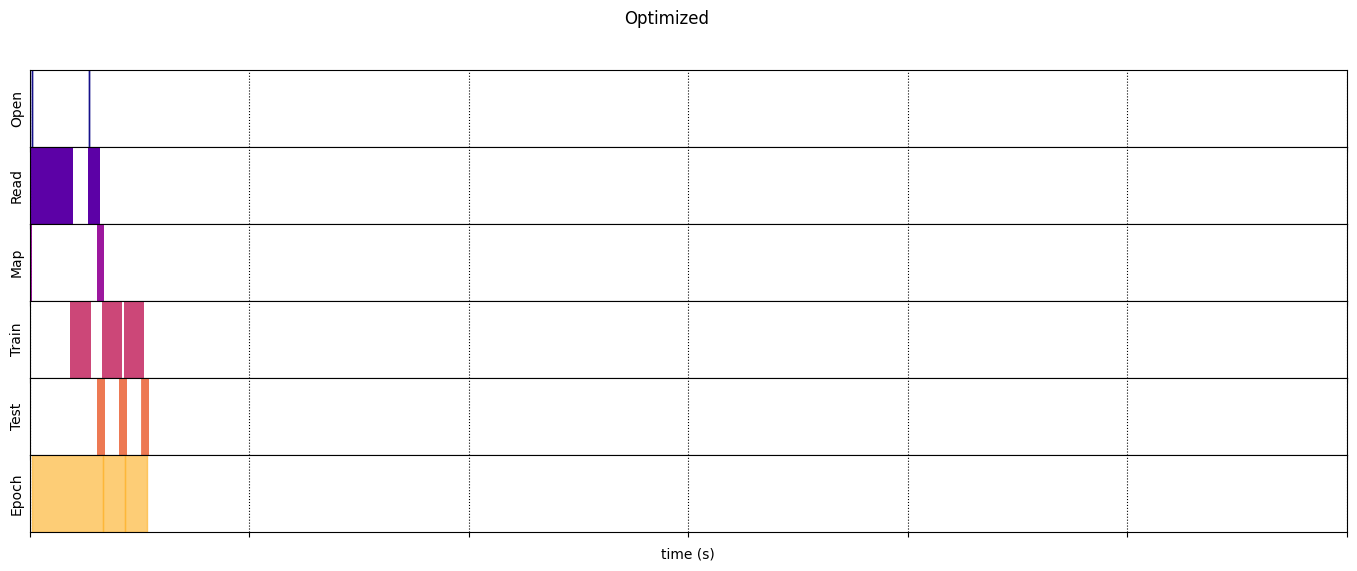

In [ ]:
draw_timeline(timeline=timeline_Optimized, title="Optimized", min_width=3000)

### Try more epochs to get better perfomance

In [24]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation, EPOCHS=5)

start time:  28038.602700083
training:


100%|██████████| 358/358 [23:42<00:00,  3.97s/it]    

testing:



100%|██████████| 89/89 [04:24<00:00,  2.98s/it]  

Epoch 1, Loss: 50.3816, Accuracy: 12.4476, test Loss: 29.4838, test Accuracy: 15.0983
training:



100%|██████████| 358/358 [34:27<00:00,  5.77s/it]    

testing:



100%|██████████| 89/89 [06:45<00:00,  4.55s/it]  

Epoch 2, Loss: 43.0602, Accuracy: 12.0810, test Loss: 50.0386, test Accuracy: 10.6742
training:



100%|██████████| 358/358 [57:05<00:00,  9.57s/it]    

testing:



100%|██████████| 89/89 [06:41<00:00,  4.51s/it]  

Epoch 3, Loss: 40.4732, Accuracy: 13.3205, test Loss: 72.6114, test Accuracy: 10.6742
training:



100%|██████████| 358/358 [46:52<00:00,  7.86s/it]    

testing:



100%|██████████| 89/89 [12:44<00:00,  8.59s/it]   

Epoch 4, Loss: 41.5281, Accuracy: 13.4602, test Loss: 57.2330, test Accuracy: 10.6742
training:



100%|██████████| 358/358 [30:02<00:00,  5.03s/it]    

testing:



100%|██████████| 89/89 [23:20<00:00, 15.74s/it]   

Epoch 5, Loss: 40.9824, Accuracy: 14.0363, test Loss: 72.2375, test Accuracy: 10.6039
Execution time: 11348.210806916999


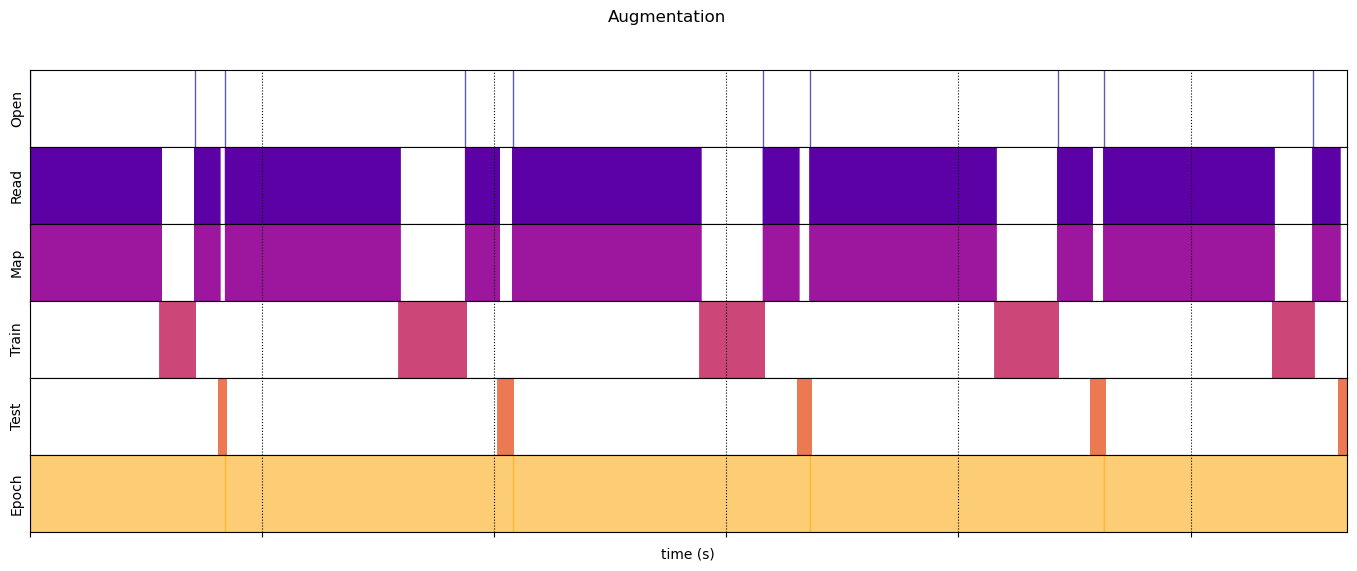

In [25]:
draw_timeline(timeline=timeline_Augmentation, title="Augmentation", min_width=3000)

在transformation的部分，我使用了shuffle, batch, map(random_crop, random_flip_left_right, random_brightness, random_constrast, per_image_standardization)))這幾種方法
和naive相比，accuracy降低了，我推測是因為training data變得更複雜了，所以需要多train幾次（增加epoch)才會有比較好的performance，而後面我也嘗試將epoch提高到5，確實test accuracy的部分有提高（請忽略最後try more epochs部分loss看起來相較於其他方法較為不同的部分，這是因為其他部分是在colab上跑的loss會較為正常，但我直接用我的電腦跑看起來就會比較奇怪）
而time consumption的部分，相較於naive的方法，time consumption較低，這是因為使用了batch的緣故

在optimization term的部分，我使用了prefetching, interleave, caching，所以相較於naive的方法以及沒有optimaization term這兩種方法，這個方法的time consumption是最少的; 而accuracy的部分，相較於naive(沒有使用augmentation)的方法，augmentation with optimization term能夠有較高的accuracy，和僅有augmentation在使用同樣epoch的情況下，有optimization term的方法也能夠有較高的accuracy